## RQ2. How frequent are, and what are the main characteristics of long-lived bugs in FLOSS projects?

## Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| OSS Project                |        Eclipse       |
| Number of Bug Reports      |        10000         |
| Threshold (in days)        |          365         |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup experimental environment.

In [1]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup matplotlib and seaborn
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

sns.set_context("paper")
sns.set_style("ticks")
sns.despine()


# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
bug_reports_path = 'datasets/20190830_eclipse_bug_report_data.csv'
bug_reports_history_path = 'datasets/20190830_eclipse_bug_report_history_data.csv'

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

[nltk_data] Downloading package punkt to /home/luiz/nltk_data...


Setup complete


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 432x288 with 0 Axes>

## Step 2. Load data.

In [2]:

!echo "Header of bug reports file"
!head -n 2 $bug_reports_path

!echo "\nNumber of lines in the file:"
!wc -l $bug_reports_path


Header of bug reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of detached objects,"Cloned from: 354395: containsAll returns wrong result in case of detached objects

Number of lines in the file:
387100 datasets/20190830_eclipse_bug_report_data.csv


In [3]:
# read bug reports data.
bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
rows_and_cols = bug_reports_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns.\n")
print(bug_reports_data.info())

# save the dataframe for machine learning experiments.
filename, file_extension = os.path.splitext(bug_reports_path)
bug_reports_data.to_csv(filename + "_small" + file_extension, index=False)

There are 10000 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
bug_id                  10000 non-null object
creation_date           10000 non-null object
component_name          10000 non-null object
product_name            10000 non-null object
short_description       10000 non-null object
long_description        9846 non-null object
assignee_name           10000 non-null object
reporter_name           10000 non-null object
resolution_category     10000 non-null object
resolution_code         10000 non-null int64
status_category         10000 non-null object
status_code             10000 non-null int64
update_date             10000 non-null object
quantity_of_votes       10000 non-null int64
quantity_of_comments    10000 non-null int64
resolution_date         10000 non-null object
bug_fix_time            10000 non-null int64
severity_category       10000 non-null object
severity_code           10000 no

In [4]:
!echo "Header of bug reports history file"
!head -n 2 $bug_reports_history_path

!echo "\nNumber of lines in the history file:"
!wc -l $bug_reports_history_path


Header of bug reports history file
Key,Who,When,What,Removed,Added
EMF-354412,stepper,2011-08-10,status,new,assigned

Number of lines in the history file:
192050 datasets/20190830_eclipse_bug_report_history_data.csv


In [5]:
# read bug reports data.
bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
rows_and_cols = bug_reports_history_data.shape

# print dataframe information.
print(bug_reports_history_data.info())
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns.\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192049 entries, 0 to 192048
Data columns (total 6 columns):
Key        192049 non-null object
Who        192049 non-null object
When       192049 non-null object
What       192049 non-null object
Removed    146419 non-null object
Added      190443 non-null object
dtypes: object(6)
memory usage: 8.8+ MB
None
There are 192049 rows and 6 columns.



## Step 3. Review the data

In [6]:
bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,closed,6,2012-09-21,0,5,2011-08-10,0,normal,2
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,resolved,4,2010-03-03,0,6,2009-04-29,177,normal,2
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,resolved,4,2011-03-02,0,5,2011-03-02,1,normal,2
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,resolved,4,2010-03-24,0,7,2006-08-29,50,major,4
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,resolved,4,2013-04-02,0,3,2013-04-02,264,critical,5


In [7]:
bug_reports_data.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,10000.0,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.0,4.689800,0.04770,5.838100,108.530300,2.371500
std,0.0,0.950719,0.71153,5.797107,317.657809,0.964148
min,1.0,4.000000,0.00000,1.000000,0.000000,1.000000
25%,1.0,4.000000,0.00000,3.000000,1.000000,2.000000
50%,1.0,4.000000,0.00000,4.000000,8.000000,2.000000
75%,1.0,6.000000,0.00000,7.000000,63.000000,2.000000
max,1.0,6.000000,46.00000,182.000000,4961.000000,6.000000


In [8]:
bug_reports_history_data.head()

,Key,Who,When,What,Removed,Added
0,EMF-354412,stepper,2011-08-10,status,new,assigned
1,EMF-354412,stepper,2011-08-10,assignee,emf.cdo-inbox,stepper
2,EMF-354412,stepper,2011-08-10,status,assigned,resolved
3,EMF-354412,stepper,2011-08-10,resolution,---,fixed
4,EMF-354412,stepper,2012-09-21,status,resolved,closed


## Step 4. Pre-processing the data

In [23]:
bug_reports_data['short_description'] = bug_reports_data['short_description'].fillna("")
bug_reports_data['long_description']  = bug_reports_data['long_description'].fillna("")
bug_reports_data['short_description_words'] = bug_reports_data['short_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_description_words']  = bug_reports_data['long_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_lived?']  = bug_reports_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')
bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,short_description_words,long_description_words,long_lived?
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,...,2012-09-21,0,5,2011-08-10,0,normal,2,9,134,short-lived
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,...,2010-03-03,0,6,2009-04-29,177,normal,2,8,179,short-lived
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,...,2011-03-02,0,5,2011-03-02,1,normal,2,7,23,short-lived
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,...,2010-03-24,0,7,2006-08-29,50,major,4,7,29,short-lived
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,...,2013-04-02,0,3,2013-04-02,264,critical,5,14,73,short-lived


## Step 5. How frequent are long-lived bugs?

[None]

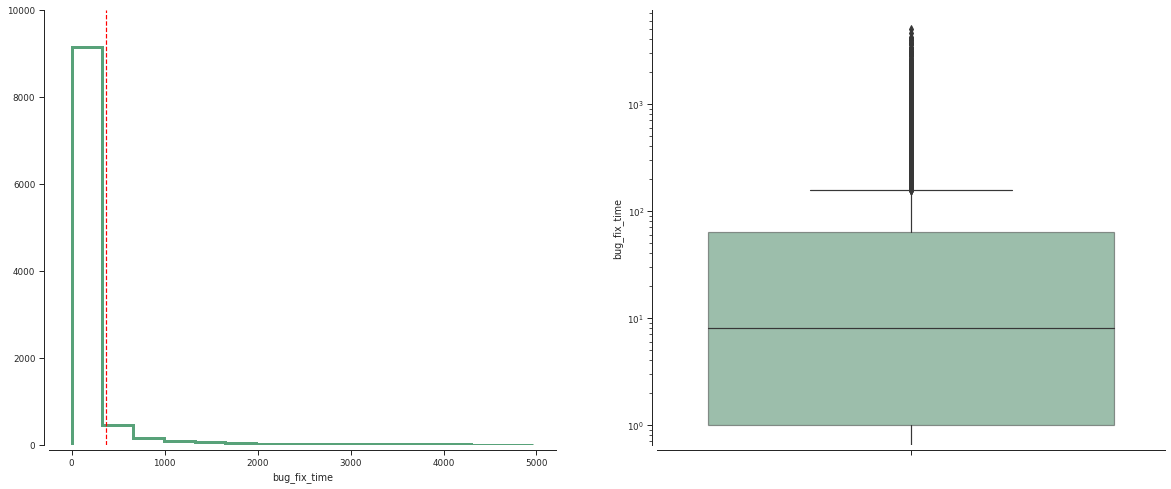

In [24]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
sns.despine(offset=5)
sns.color_palette("Paired")

# Long-lived? histogram distribution
g = sns.distplot(bug_reports_data['bug_fix_time']
                 , kde=False, kde_kws={"color": "b", "alpha": 0.5, "lw": 3}, bins=15
                 , hist=True, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 0.8, "color": "seagreen"}
                 , ax=ax[0])
g.set(ylim=(0, 10000))

g.axvline(bug_fix_time_threshold, color='r', linestyle='--'
          , label = f"Threshold : {bug_fix_time_threshold}")

g = sns.boxplot(y="bug_fix_time"
                , data=bug_reports_data
                , showfliers=True, ax=ax[1]
                , palette=["seagreen"]
                , boxprops=dict(alpha=.5)
)
g.set(yscale="log")

([<matplotlib.patches.Wedge at 0x7f03174d8a90>,
 [Text(-1.068302626145748, 0.26216311519757773, 'short-lived'),
  Text(1.0683026138730054, -0.26216316520843325, 'long-lived')],
 [Text(-0.5827105233522261, 0.14299806283504238, '92.3%'),
  Text(0.5827105166580029, -0.14299809011369086, '7.7%')])

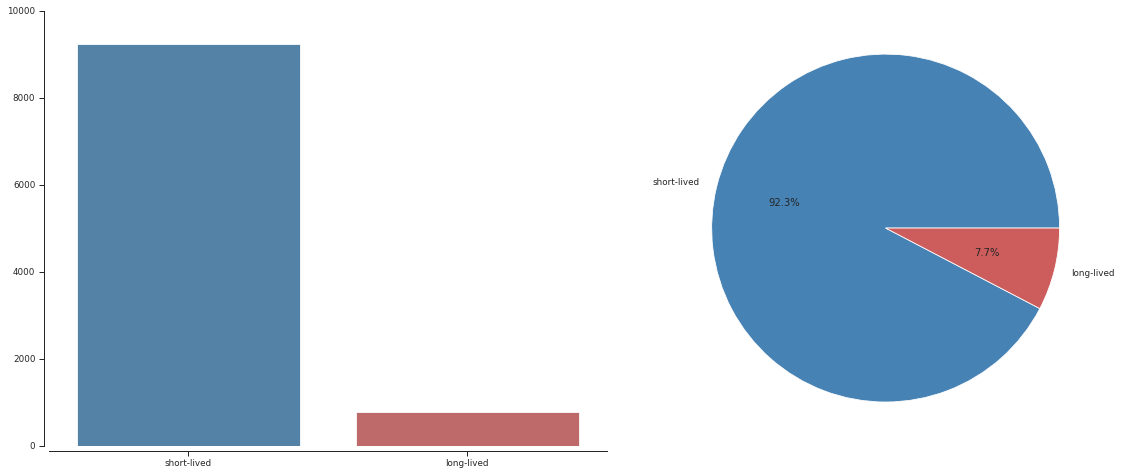

In [11]:
bug_reports_count = bug_reports_data["long_lived?"].value_counts()

# bar plot
f, ax = plt.subplots(figsize=(20,8), ncols=2)
plt.subplots_adjust(wspace=0, hspace=1)
sns.despine(offset=5)
sns.set_palette("deep")
g = sns.barplot(
      x=bug_reports_count.index
    , y=bug_reports_count.values
    , palette=[ "steelblue", "indianred"]
    , ax=ax[0]
)
g.set(ylim=(0, 10000))

# pie plot
ax[1].pie(
    bug_reports_count.values
    , labels=bug_reports_count.index, autopct='%1.1f%%'
    , colors=["steelblue", "indianred"]
)



## Step 6. Bug Reporter

In [12]:
number_of_reports   = bug_reports_data['bug_id'].count()
number_of_reporters = bug_reports_data['reporter_name'].nunique()
print(f"{number_of_reporters} reporters reported {number_of_reports} bugs.")

2876 reporters reported 10000 bugs.


In [13]:
top_10_reporters = bug_reports_data.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter_name,
david_williams,139
eclipse,108
markus.kell.r,85
wayne.beaton,82
ed,76
pascal,71
john.arthorne,69
Lars.Vogel,69
daniel_megert,64


[None]

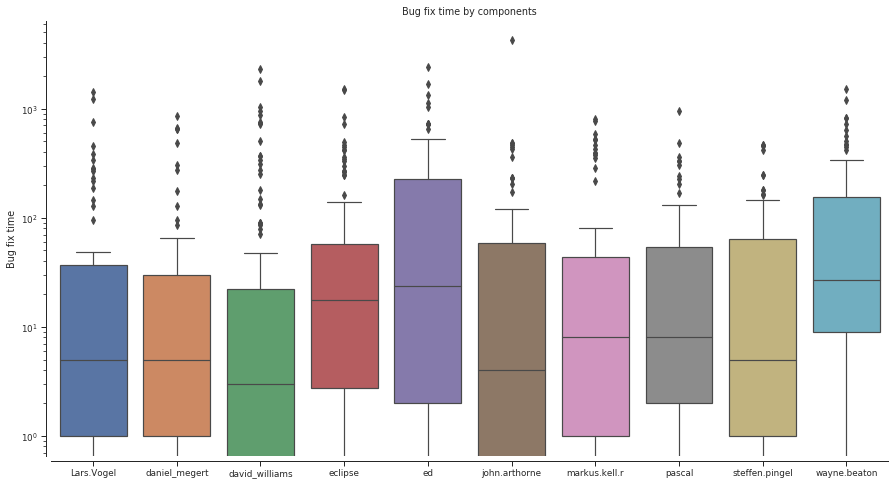

In [14]:
bug_reports_data_for_top_10_reporters=bug_reports_data[bug_reports_data['reporter_name'].isin(top_10_reporters.index)]
bug_reports_data_for_top_10_reporters=bug_reports_data_for_top_10_reporters.sort_values(by=['reporter_name'])

fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
sns.set_palette("deep")
g = sns.boxplot(data=bug_reports_data_for_top_10_reporters
            , x="reporter_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by reporter')]

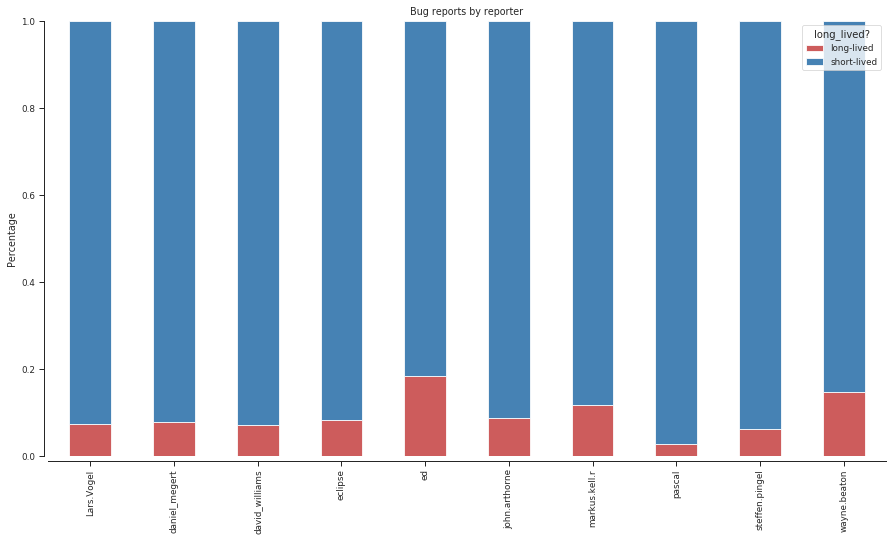

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)

palette=color=["indianred", "steelblue"]
bug_reports_data_grouped = bug_reports_data_for_top_10_reporters.groupby("reporter_name")['long_lived?'].value_counts(normalize=True).unstack()

bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=ax)
ax.set(ylim=(0, 1))
ax.set(title="Bug reports by reporter", xlabel="", ylabel="Percentage")


## Step 7. Assignee

In [16]:
top_10_assignee = bug_reports_data.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:10]
top_10_assignee

,count
assignee_name,
webmaster,191
rap-inbox,111
tmf.xtext-inbox,105
Silenio_Quarti,90
emo,81
eclipse,76
david_williams,76
pde-ui-inbox,75
ci.admin-inbox,70


[None]

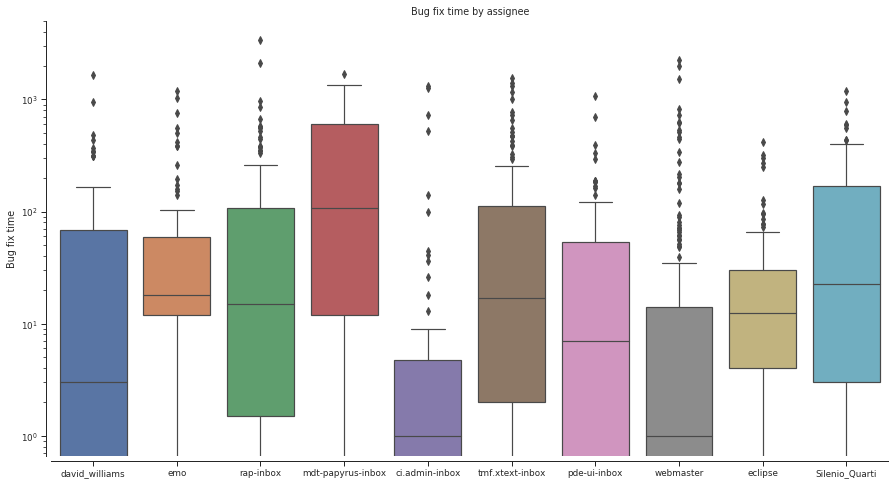

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_assignee=bug_reports_data[bug_reports_data['assignee_name'].isin(top_10_assignee.index)] 

sns.despine(offset=5)
g = sns.boxplot(data=bug_reports_data_for_top_10_assignee
            , x="assignee_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by assignee", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by assignee')]

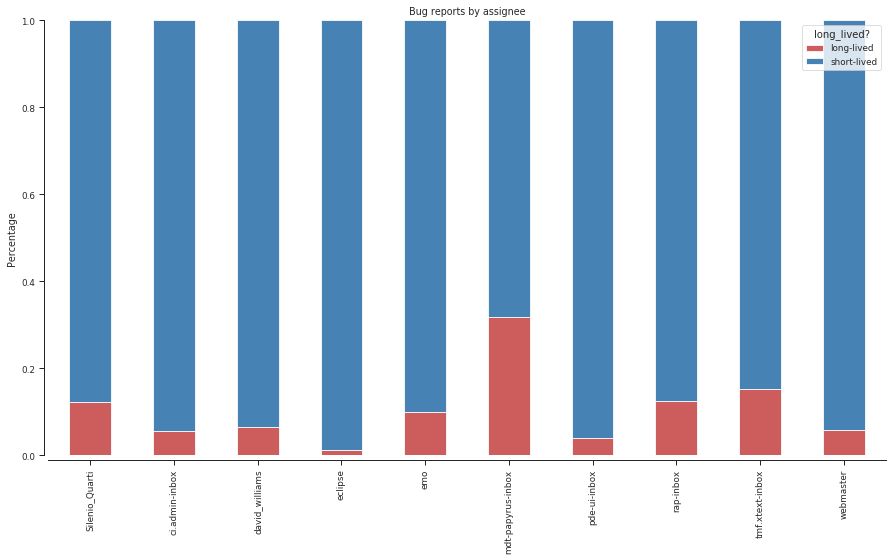

In [18]:
bug_reports_data_grouped = bug_reports_data_for_top_10_assignee.groupby("assignee_name")['long_lived?'].value_counts(normalize=True).unstack()

# stacked bar plot.
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=["indianred", "steelblue"], ax=ax)
ax.set(ylim=(0, 1))
ax.set(title="Bug reports by assignee", xlabel="", ylabel="Percentage")

## Step 8. Component

In [19]:
top_10_component = bug_reports_data.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component_name,
UI,1063
Core,785
SWT,344
TPTP,307
Releng,195
General,194
Client,168
Hyades,142
cdt-core,137


[None]

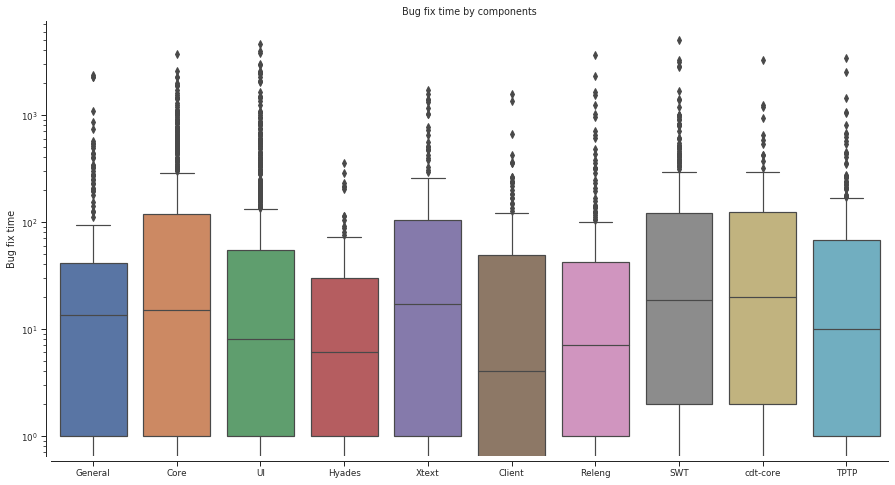

In [20]:
bug_reports_data_for_top_10_component=bug_reports_data[bug_reports_data['component_name'].isin(top_10_component.index)] 

# plot boxplot chart
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
g = sns.boxplot(data=bug_reports_data_for_top_10_component
            , x="component_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by components')]

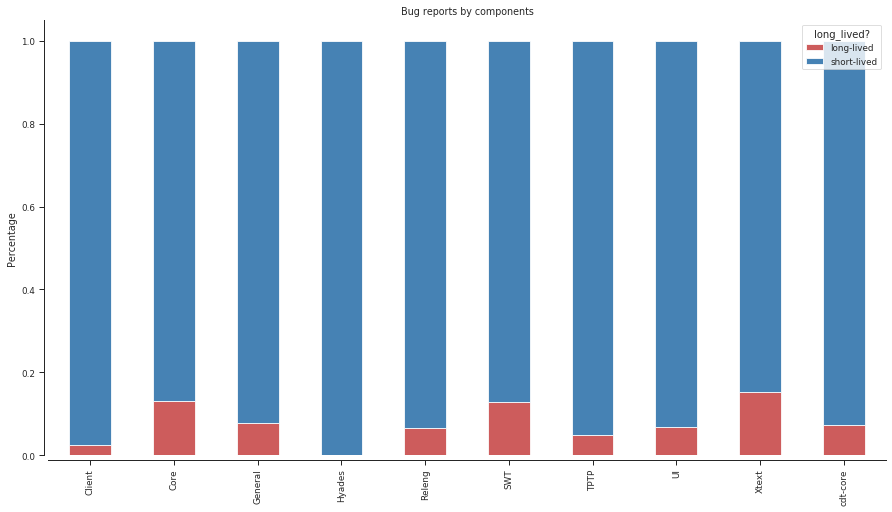

In [25]:
# group data.
bug_reports_data_grouped = bug_reports_data_for_top_10_component.groupby("component_name")['long_lived?'].value_counts(normalize=True).unstack()


fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=["indianred", "steelblue"], ax=ax)
ax.set(title="Bug reports by components", xlabel="", ylabel="Percentage")

## Step 9. Analysis of Short and Long Descrption

### How is the distribution of number of words

[Text(0, 0.5, 'Number of words'),
 Text(0.5, 0, ' '),
 Text(0.5, 1.0, 'Distribution of number of words in short description')]

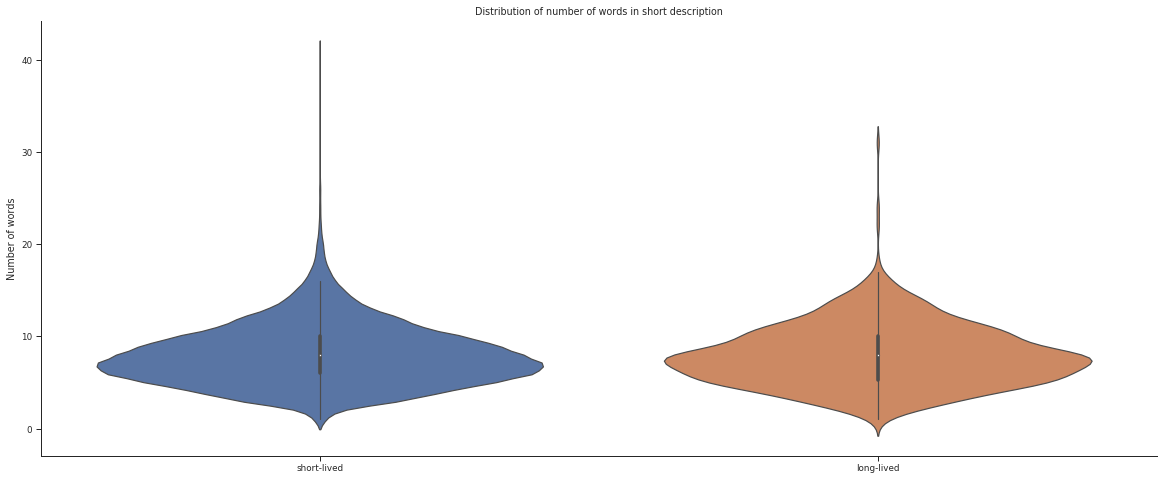

In [26]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="short_description_words", data=bug_reports_data)
g = sns.boxplot(x="long_lived?", y="short_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in short description", ylabel="Number of words", xlabel=" ")
#g.set(yscale="log")

[None]

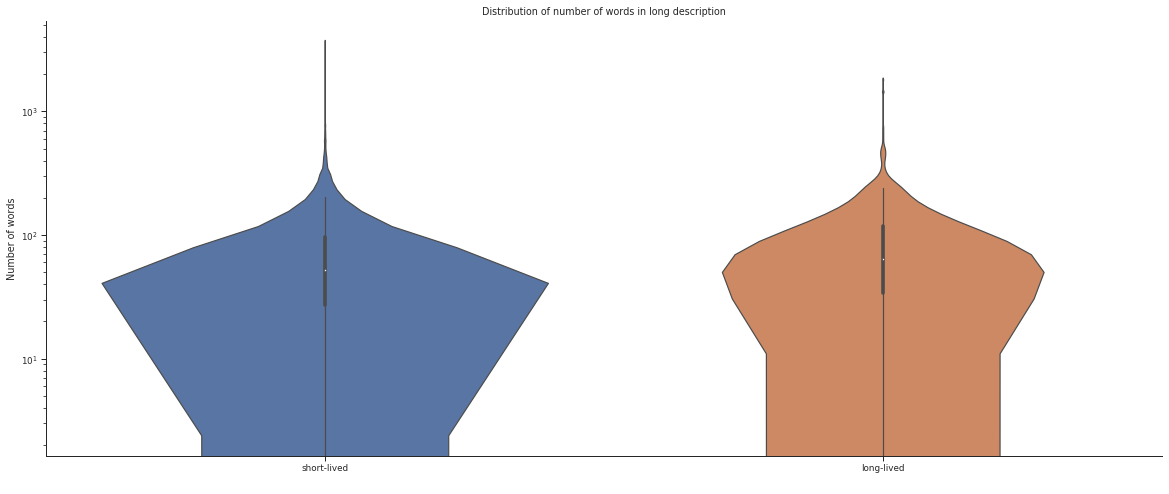

In [27]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="long_description_words", data=bug_reports_data)
#g = sns.boxplot(x="long_lived?", y="long_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in long description", ylabel="Number of words", xlabel=" ")
g.set(yscale="log")

### Short Description Word cloud

In [ ]:
def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    else:
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title)
    axe.axis("off")

def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['eclipse', 'org', 'xml', 'java', 'project', 'view', 'editor', 'file', 'test', 'update', 'will'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, 'Word Cloud for {} [Short-Lived Bugs]'.format(title), ax[0])
    plot_one_word_cloud(ll_text, 'Word Cloud for {} [Long-Lived Bugs]'.format(title), ax[1])


    

In [ ]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description')

### Short Description Word cloud with Text Mining

In [ ]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description', True)

### Long Description Word cloud

In [ ]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Short Description', False)

### Long Description Word cloud with Text Mining

In [ ]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Long Description', True)

## Step 10. Analysis of Severity Level

### Severity level distribution

In [ ]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
bug_reports_data_grouped = bug_reports_data.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of severity level", xlabel="", ylabel="Percentage")


In [ ]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

g1 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='long-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[0])
g1.set(title="long-lived", xlabel="")
g1.set(yscale="log")

g2 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='short-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[1])
g2.set(title="short-lived", xlabel="")
g2.set(yscale="log")


### Number of Changes

In [ ]:
severity_levels = {'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6, 'enhancement':0}
bug_reports_history_merged = pd.merge(
    bug_reports_history_data,
    bug_reports_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?']],
    left_on='Key',
    right_on='bug_id',
    how='left'
)
    
severity_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'severity')]
severity_changes_data.loc[:, 'Removed'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Removed']]
severity_changes_data.loc[:, 'Added'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Added']]
severity_changes_data['Change'] = severity_changes_data['Added'] - severity_changes_data['Removed']

sns.catplot(x="Change", col="long_lived?",data=severity_changes_data, kind="count",height=8, aspect=1);



In [ ]:
bug_reports_history_data[(bug_reports_history_data['What'] == 'assignee')]